In [6]:
import os
import numpy as np
import torch
import torch.nn as nn
from scipy import io
import matplotlib.pyplot as plt
import math

# Define models exactly matching the original code structure
class Conv2d(nn.Module):
    def __init__(self, nch_in, nch_out, kernel_size=4, stride=1, padding=1, bias=True):
        super(Conv2d, self).__init__()
        self.conv = nn.Conv2d(nch_in, nch_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)

    def forward(self, x):
        return self.conv(x)

class Norm2d(nn.Module):
    def __init__(self, nch, norm_mode):
        super(Norm2d, self).__init__()
        if norm_mode == 'bnorm':
            self.norm = nn.BatchNorm2d(nch)
        elif norm_mode == 'inorm':
            self.norm = nn.InstanceNorm2d(nch)

    def forward(self, x):
        return self.norm(x)

class ReLU(nn.Module):
    def __init__(self, relu):
        super(ReLU, self).__init__()
        if relu > 0:
            self.relu = nn.LeakyReLU(relu, True)
        elif relu == 0:
            self.relu = nn.ReLU(True)

    def forward(self, x):
        return self.relu(x)

class Padding(nn.Module):
    def __init__(self, padding, padding_mode='zeros', value=0):
        super(Padding, self).__init__()
        if padding_mode == 'reflection':
            self.padding = nn.ReflectionPad2d(padding)
        elif padding_mode == 'replication':
            self.padding = nn.ReplicationPad2d(padding)
        elif padding_mode == 'constant':
            self.padding = nn.ConstantPad2d(padding, value)
        elif padding_mode == 'zeros':
            self.padding = nn.ZeroPad2d(padding)

    def forward(self, x):
        return self.padding(x)

class CNR2d(nn.Module):
    def __init__(self, nch_in, nch_out, kernel_size=4, stride=1, padding=1, norm='bnorm', relu=0.0, drop=[], bias=[]):
        super().__init__()

        if bias == []:
            if norm == 'bnorm':
                bias = False
            else:
                bias = True

        layers = []
        layers += [Conv2d(nch_in, nch_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)]

        if norm != []:
            layers += [Norm2d(nch_out, norm)]

        if relu != []:
            layers += [ReLU(relu)]

        if drop != []:
            layers += [nn.Dropout2d(drop)]

        self.cbr = nn.Sequential(*layers)

    def forward(self, x):
        return self.cbr(x)

class ResBlock(nn.Module):
    def __init__(self, nch_in, nch_out, kernel_size=3, stride=1, padding=1, padding_mode='reflection', norm='inorm', relu=0.0, drop=[], bias=[]):
        super().__init__()

        if bias == []:
            if norm == 'bnorm':
                bias = False
            else:
                bias = True

        layers = []

        # 1st conv
        layers += [Padding(padding, padding_mode=padding_mode)]
        layers += [CNR2d(nch_in, nch_out, kernel_size=kernel_size, stride=stride, padding=0, norm=norm, relu=relu)]

        if drop != []:
            layers += [nn.Dropout2d(drop)]

        # 2nd conv
        layers += [Padding(padding, padding_mode=padding_mode)]
        layers += [CNR2d(nch_in, nch_out, kernel_size=kernel_size, stride=stride, padding=0, norm=norm, relu=[])]

        self.resblk = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.resblk(x)

class ResNet(nn.Module):
    def __init__(self, nch_in, nch_out, nch_ker=64, norm='bnorm', nblk=16):
        super(ResNet, self).__init__()

        self.nch_in = nch_in
        self.nch_out = nch_out
        self.nch_ker = nch_ker
        self.norm = norm
        self.nblk = nblk

        if norm == 'bnorm':
            self.bias = False
        else:
            self.bias = True

        self.enc1 = CNR2d(self.nch_in, self.nch_ker, kernel_size=3, stride=1, padding=1, norm=[], relu=0.0)

        res = []
        for i in range(self.nblk):
            res += [ResBlock(self.nch_ker, self.nch_ker, kernel_size=3, stride=1, padding=1, norm=self.norm, relu=0.0, padding_mode='reflection')]
        self.res = nn.Sequential(*res)

        self.dec1 = CNR2d(self.nch_ker, self.nch_ker, kernel_size=3, stride=1, padding=1, norm=norm, relu=[])

        self.conv1 = Conv2d(self.nch_ker, self.nch_out, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.enc1(x)
        x0 = x

        x = self.res(x)

        x = self.dec1(x)
        x = x + x0

        x = self.conv1(x)

        return x

# PSNR calculation function
def calculate_psnr(img1, img2, data_range=1.0):
    """Calculate PSNR between two images"""
    if isinstance(img1, torch.Tensor):
        img1 = img1.detach().cpu().numpy()
    if isinstance(img2, torch.Tensor):
        img2 = img2.detach().cpu().numpy()
    
    # Ensure images have the same shape
    assert img1.shape == img2.shape, f"Images must have the same dimensions. Got {img1.shape} and {img2.shape}"
    
    # Calculate MSE
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')  # Perfect similarity
    
    # Calculate PSNR
    psnr = 20 * math.log10(data_range / math.sqrt(mse))
    
    return psnr

import pydicom

def load_image(file_path, expected_key):
    """Loads an image from .mat or .IMA format"""
    if file_path.endswith('.mat'):
        mat = io.loadmat(file_path)
        if expected_key in mat:
            return mat[expected_key].astype(np.float32)
        else:
            # Try fallback: first non-meta key
            keys = [k for k in mat.keys() if not k.startswith('__')]
            return mat[keys[0]].astype(np.float32)
    elif file_path.endswith('.IMA'):
        dcm = pydicom.dcmread(file_path)
        image = dcm.pixel_array.astype(np.float32)
        # Optional: HU correction
        if hasattr(dcm, "RescaleIntercept") and hasattr(dcm, "RescaleSlope"):
            image = image * float(dcm.RescaleSlope) + float(dcm.RescaleIntercept)
        return image
    else:
        raise ValueError(f"Unsupported file format: {file_path}")

def denoise_and_evaluate(model_path, clean_path, noisy_path, norm_method='adaptive', output_dir=None):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load model
    print(f"Loading model from {model_path}")
    model = ResNet(nch_in=1, nch_out=1, nch_ker=64, norm='bnorm')
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['netG'])        
    model.to(device)
    model.eval()

    # Load clean & noisy images from .IMA or .mat
    clean_img = load_image(clean_path, expected_key='clean_image')
    noisy_img = load_image(noisy_path, expected_key='noisy_image')

    # Preprocess
    clean_img = clean_img.astype(np.float32)
    noisy_img = noisy_img.astype(np.float32)

    def normalize_image(img, method='adaptive'):
        min_val, max_val = img.min(), img.max()
        if max_val > min_val:
            norm = (img - min_val) / (max_val - min_val)
        else:
            norm = np.zeros_like(img)
        return norm  # CLAHE can be added later if needed

    clean_norm = normalize_image(clean_img, norm_method)
    noisy_norm = normalize_image(noisy_img, norm_method)
    noisy_input = np.expand_dims(noisy_norm, axis=(0, 1))  # [H,W] -> [1,1,H,W]
    noisy_tensor = torch.from_numpy(noisy_input).to(device)

    # Inference
    print("Running denoising model...")
    with torch.no_grad():
        output_tensor = model(noisy_tensor)
    output = output_tensor.cpu().numpy().squeeze()

    # Postprocess for evaluation and display
    clean_img_2d = clean_norm.squeeze()
    noisy_img_2d = noisy_norm.squeeze()
    output_img_2d = output.squeeze()

    if len(output_img_2d.shape) == 3 and output_img_2d.shape[0] <= 3:
        output_img_2d = np.transpose(output_img_2d, (1, 2, 0))

    # PSNR
    psnr_noisy = calculate_psnr(clean_img_2d, noisy_img_2d)
    psnr_output = calculate_psnr(clean_img_2d, output_img_2d)

    print(f"PSNR between Original and Noisy: {psnr_noisy:.2f} dB")
    print(f"PSNR between Original and Denoised: {psnr_output:.2f} dB")
    print(f"PSNR Improvement: {psnr_output - psnr_noisy:.2f} dB")

    # Visualization
    plt.figure(figsize=(15, 5))
    plt.subplot(131); plt.imshow(clean_img_2d, cmap='gray'); plt.title('Original'); plt.axis('off')
    plt.subplot(132); plt.imshow(noisy_img_2d, cmap='gray'); plt.title(f'Noisy (PSNR: {psnr_noisy:.2f} dB)'); plt.axis('off')
    plt.subplot(133); plt.imshow(output_img_2d, cmap='gray'); plt.title(f'Denoised (PSNR: {psnr_output:.2f} dB)'); plt.axis('off')
    plt.tight_layout()

    # Save results
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        clean_file = os.path.basename(clean_path).split('.')[0]
        noisy_file = os.path.basename(noisy_path).split('.')[0]

        plt.savefig(os.path.join(output_dir, 'denoising_result.png'), dpi=300)
        plt.imsave(os.path.join(output_dir, f"{clean_file}_original.png"), clean_img_2d, cmap='gray')
        plt.imsave(os.path.join(output_dir, f"{noisy_file}_noisy.png"), noisy_img_2d, cmap='gray')
        plt.imsave(os.path.join(output_dir, f"{noisy_file}_denoised.png"), output_img_2d, cmap='gray')

        io.savemat(os.path.join(output_dir, f"{clean_file}_original.mat"), {'clean_image': clean_img_2d})
        io.savemat(os.path.join(output_dir, f"{noisy_file}_noisy.mat"), {'noisy_image': noisy_img_2d})
        io.savemat(os.path.join(output_dir, f"{noisy_file}_denoised.mat"), {'denoised_image': output_img_2d})

        print(f"Results saved to {output_dir}")

    plt.show()

    return {
        'original': clean_img,
        'noisy': noisy_img,
        'denoised': output,
        'psnr_noisy': psnr_noisy,
        'psnr_denoised': psnr_output,
        'improvement': psnr_output - psnr_noisy
    }


Using device: cpu
Loading model from ../Downloads/model_epoch0160.pth
Running denoising model...
PSNR between Original and Noisy: 39.87 dB
PSNR between Original and Denoised: 40.55 dB
PSNR Improvement: 0.67 dB


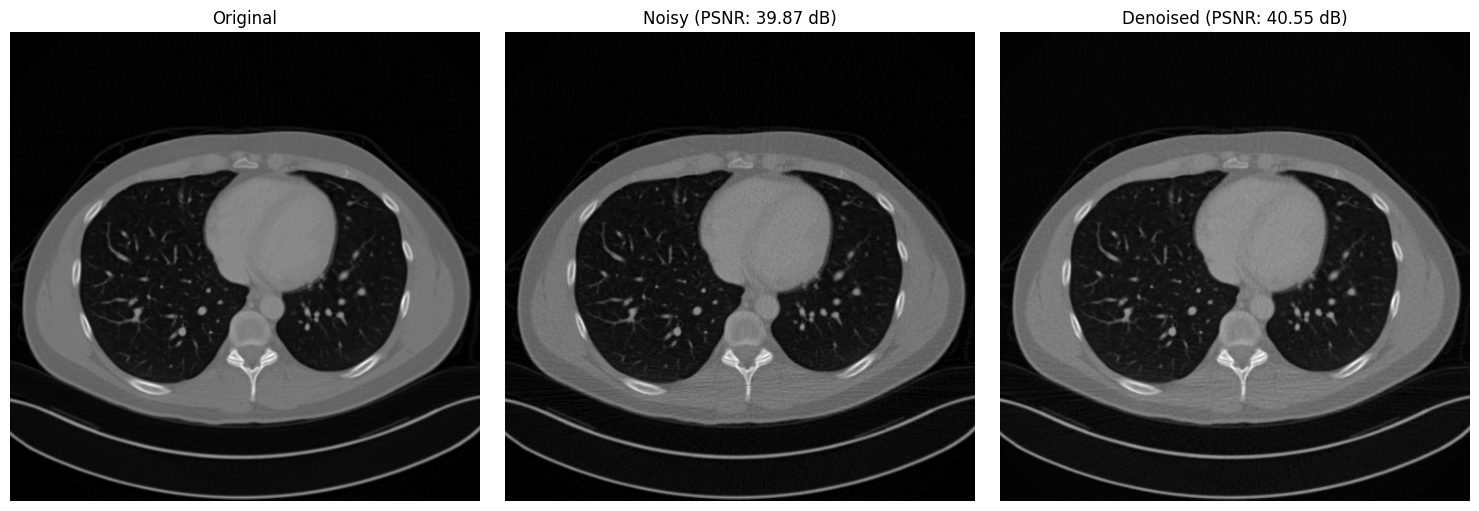

In [7]:
results = denoise_and_evaluate(
    model_path="../Downloads/model_epoch0160.pth",
    clean_path="../Downloads/Dataset_AAPM/FD_QD/FD/L333/full_3mm/L333_FD_3_1.CT.0001.0001.2015.12.22.20.18.05.702762.358508309.IMA",
    noisy_path="../Downloads/Dataset_AAPM/FD_QD/QD/L333/quarter_3mm/L333_QD_3_1.CT.0003.0001.2015.12.22.20.44.15.611815.358721840.IMA",
)